# Projet Platformes Big Data
## Analyse des données de vols avec Apache Spark
### Presenté par DABGO Ariane
### Professeur: Mr PREIRA

Le projet consiste à analyser les données de vols aux États-Unis sur trois années consécutives à l'aide d'Apache Spark, en réalisant des requêtes analytiques et des visualisations pour identifier les tendances et obtenir des statistiques sur les vols annulés.

Notre choix s'est porté sur les années 2000, 2001 et 2002.


Pour la réalisation des requêtes analytiques, nous avons utilisé certaines fonctions:
 
  ##### groupBy(column) : 
    Permet de regrouper les données selon les valeurs d'une ou plusieurs colonnes.
    
   ##### agg(aggregationFunction("column")):
    Applique une fonction d'agrégation (comme count, sum, avg) aux données groupées.
    
   ##### withColumn("column", newColumnValue) : 
    Ajoute ou remplace une colonne dans le DataFrame avec de nouvelles valeurs.

   ##### withColumnRenamed() : 
    Renomme une colonne dans un DataFrame.
    
   ##### toPandas(): 
    Convertit un DataFrame Spark en DataFrame Pandas pour l'analyse et la visualisation avec des bibliothèques Python
    
   ##### count("column") :
    Compte le nombre de valeurs non nulles dans une colonne spécifiée.
    
   ##### avg("column") : 
    Calcule la moyenne des valeurs dans une colonne spécifiée.
    
   ##### sum("column") : 
    Calcule la somme des valeurs dans une colonne spécifiée.

   ##### filter(condition) :
    Filtre les lignes du DataFrame en fonction de la condition spécifiée.
    
   ##### dayofyear(col("date")) : 
    Extrait le jour de l'année à partir d'une colonne de date.
    
   ##### to_date(col("dateString")) :
    Convertit une chaîne de caractères représentant une date en un type date.

   ##### pivot(column, values)
    Crée une table croisée dynamique en pivotant les valeurs d'une colonne sur des colonnes distinctes.

   ##### cast(data_type) : 
    Convertit les données d'une colonne dans un type de données spécifique.

   
        

## I. Creation de la SparkSession

### Import de bibliothèques

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import col, expr, to_date, dayofyear
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
#Creation de la SparkSession
spark = SparkSession.builder.appName("Analyse de données de vols").getOrCreate()

### Import des différents fichiers CSV

In [10]:
df_2000 = spark.read.csv("2000.csv", header=True, inferSchema=True)
df_2001 = spark.read.csv("2001.csv", header=True, inferSchema=True)
df_2002 = spark.read.csv("2002.csv", header=True, inferSchema=True)

### Creation du DataFrame airlineDF

In [12]:
#Mise en commun des 3 fichiers CSV
airlineDF = df_2000.union(df_2001).union(df_2002)

In [13]:
#Affichage des 5 premieres lignes du dataframe
airlineDF.show(5)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2000|    1|        28|        5|   1647|      1647|   1906|      1859|           HP|      154

In [14]:
#Afficher la structure, y compris les différentes colonnes
airlineDF.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- C

## II. Création du second DataFrame

In [16]:
#sélection des colonnes à utiliser
selected_columns = ["Year", "Month", "DayofMonth", "DepTime", "ArrTime", "UniqueCarrier", "Origin", "Dest", "Cancelled"]

#Création du 2e dataframe nommé secondDF
secondDF = airlineDF.select([col(column) for column in selected_columns])

In [17]:
# Remplacement des types de données des colonnes dans secondDF par des types appropriés
secondDF = secondDF.withColumn("Year", col("Year").cast(IntegerType())) \
                       .withColumn("Month", col("Month").cast(IntegerType())) \
                       .withColumn("DayofMonth", col("DayofMonth").cast(IntegerType())) \
                       .withColumn("DepTime", col("DepTime").cast(IntegerType())) \
                       .withColumn("ArrTime", col("ArrTime").cast(IntegerType())) \
                       .withColumn("UniqueCarrier", col("UniqueCarrier").cast(StringType())) \
                       .withColumn("Origin", col("Origin").cast(StringType())) \
                       .withColumn("Dest", col("Dest").cast(StringType())) \
                       .withColumn("Cancelled", col("Cancelled").cast(IntegerType()))

In [18]:
#Affichage des 5 premières lignes du dataframe
secondDF.show(5)

+----+-----+----------+-------+-------+-------------+------+----+---------+
|Year|Month|DayofMonth|DepTime|ArrTime|UniqueCarrier|Origin|Dest|Cancelled|
+----+-----+----------+-------+-------+-------------+------+----+---------+
|2000|    1|        28|   1647|   1906|           HP|   ATL| PHX|        0|
|2000|    1|        29|   1648|   1939|           HP|   ATL| PHX|        0|
|2000|    1|        30|   NULL|   NULL|           HP|   ATL| PHX|        1|
|2000|    1|        31|   1645|   1852|           HP|   ATL| PHX|        0|
|2000|    1|         1|    842|   1057|           HP|   ATL| PHX|        0|
+----+-----+----------+-------+-------+-------------+------+----+---------+
only showing top 5 rows



## III. Nombre de vols annulés pour chaque mois de chaque année

In [20]:
# Requete
# Regroupe les données par année et mois, calcule la somme des vols annulés pour chaque groupe, et renomme la colonne résultante en "TotalCancelled"
cancelled_flights = secondDF.groupBy("Year", "Month").agg({"Cancelled": "sum"}).withColumnRenamed("sum(Cancelled)", "TotalCancelled")

In [21]:
#Affichage
cancelled_flights.show(36)

+----+-----+--------------+
|Year|Month|TotalCancelled|
+----+-----+--------------+
|2000|    1|         24515|
|2000|    2|         15188|
|2000|    4|         11642|
|2000|    3|         10237|
|2000|    5|         16513|
|2000|    7|         15526|
|2000|    6|         18632|
|2000|    8|         14991|
|2000|    9|         10365|
|2000|   10|         10369|
|2000|   11|         10912|
|2000|   12|         28600|
|2001|    1|         19891|
|2001|    2|         17448|
|2001|    3|         17876|
|2001|    5|          9452|
|2001|    4|         11414|
|2001|    6|         15509|
|2001|    7|         11286|
|2001|    8|         13318|
|2001|    9|         99324|
|2001|   10|          6850|
|2001|   11|          4497|
|2001|   12|          4333|
|2002|    2|          4323|
|2002|    1|          7301|
|2002|    3|          6033|
|2002|    4|          4513|
|2002|    5|          4442|
|2002|    6|          7666|
|2002|    7|          6260|
|2002|    8|          5339|
|2002|    9|        

In [22]:
#Conversion en dataframe pandas pour la représentation du diagramme
pandas_df = cancelled_flights.toPandas()

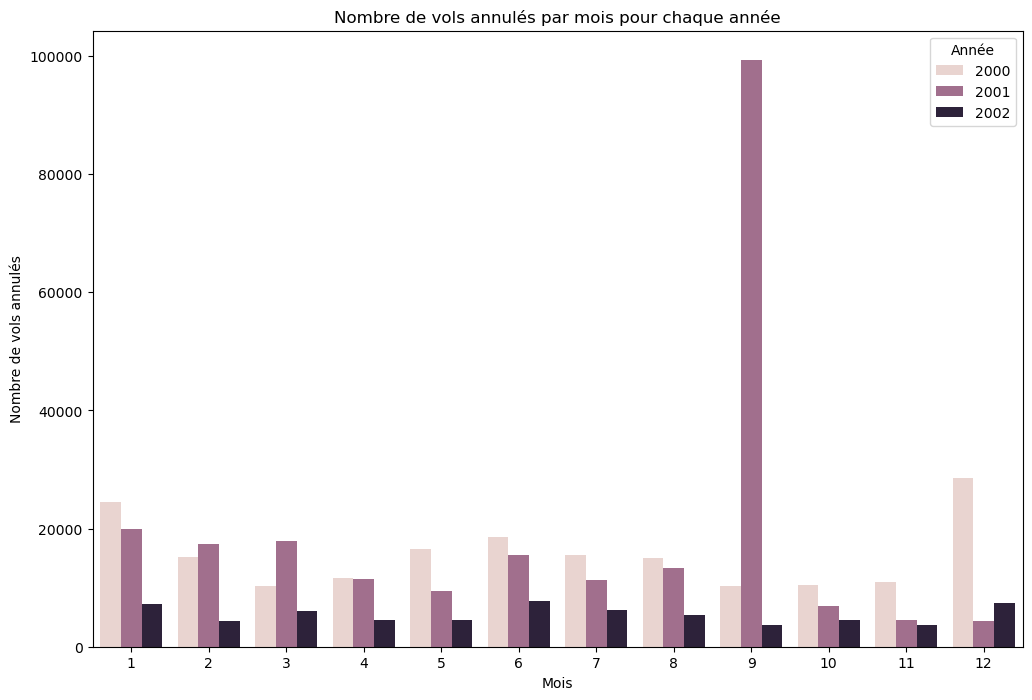

In [23]:
#Diagramme en baton
plt.figure(figsize=(12, 8))
sns.barplot(data=pandas_df, x="Month", y="TotalCancelled", hue="Year")
plt.title("Nombre de vols annulés par mois pour chaque année")
plt.xlabel("Mois")
plt.ylabel("Nombre de vols annulés")
plt.legend(title="Année")
plt.show()

Ce diagramme en bâton révèle que le plus grand nombre de vols annulés a été enregistré en septembre 2001. 
Aussi, contrairement aux autres années, 2002 est celle qui enregistre le moins de vols annulés

## IV. Nombre de vols confirmés par mois pour chaque compagnies, par année

In [26]:
#Filtre des vols confirmés (cancelled == 0)
confirmedDF =secondDF.filter(col("Cancelled") == 0)

In [27]:
#Requete pour l'an 2000
#Comptage des vols confirmés par mois pour 2000
An_2000 = confirmedDF.filter(col("Year") == 2000) \
                        .groupBy("UniqueCarrier") \
                        .pivot("Month", list(range(1, 13))) \
                        .agg({"Cancelled": "count"}) \
                        .withColumnRenamed("count(Cancelled)", "TotalConfirmed")


In [28]:
#Requete pour l'an 2001
# Comptage des vols confirmés par mois pour 2001
An_2001 = confirmedDF.filter(col("Year") == 2001) \
                        .groupBy("UniqueCarrier") \
                        .pivot("Month", list(range(1, 13))) \
                        .agg({"Cancelled": "count"}) \
                        .withColumnRenamed("count(Cancelled)", "TotalConfirmed")


In [29]:
#Requete pour l'an 2002
# Comptage des vols confirmés par mois pour 2002
An_2002 = confirmedDF.filter(col("Year") == 2002) \
                        .groupBy("UniqueCarrier") \
                        .pivot("Month", list(range(1, 13))) \
                        .agg({"Cancelled": "count"}) \
                        .withColumnRenamed("count(Cancelled)", "TotalConfirmed")

In [30]:
#Dictionnaire de correspondance numéro du mois au nom du mois.
month_names = {1: "jan", 2: "fev", 3: "mar", 4: "avr", 5: "mai", 6: "juin",
                7: "juil", 8: "aout", 9: "sept", 10: "oct", 11: "nov", 12: "dec"}


In [31]:
#Fonction de conversion du numéro en nom du mois
def rename_month_columns(df):
    columns = df.columns
    for num, name in month_names.items():
        old_col = str(num)
        if old_col in columns:
            df = df.withColumnRenamed(old_col, name)
    return df

In [32]:
#Remplacement des numeros des mois des dataframes
An_2000 = rename_month_columns(An_2000)
An_2001 = rename_month_columns(An_2001)
An_2002 = rename_month_columns(An_2002)

In [33]:
#Conversion en dataframe pandas pour visualisation
pandas_An_2000 = An_2000.toPandas()
pandas_An_2001 = An_2001.toPandas()
pandas_An_2002 = An_2002.toPandas()

In [34]:
#Affichage pour l'an 2000
print("Tableau des vols confirmés pour 2000")
print(pandas_An_2000)

Tableau des vols confirmés pour 2000
   UniqueCarrier      jan      fev      mar      avr      mai     juin  \
0             UA  61229.0  58724.0  65259.0  62401.0  62049.0  61273.0   
1             AA  58067.0  55309.0  60804.0  58230.0  59684.0  58217.0   
2             NW  42854.0  41569.0  45403.0  43315.0  44456.0  45631.0   
3             HP  17077.0  15957.0  17880.0  17280.0  18114.0  17559.0   
4             TW  21662.0  20820.0  22692.0  22050.0  22347.0  22146.0   
5             DL  72828.0  68951.0  76900.0  73781.0  74784.0  72694.0   
6             US  55582.0  56026.0  61624.0  58265.0  60506.0  56953.0   
7             AQ      NaN      NaN      NaN      NaN      NaN      NaN   
8             AS  12193.0  10958.0  12558.0  11486.0  12173.0  12010.0   
9             CO  31502.0  31044.0  34166.0  31992.0  32158.0  31574.0   
10            WN  72968.0  69953.0  75421.0  72821.0  76125.0  74411.0   

       juil     aout     sept      oct    nov    dec  
0   61618.0  61503.

In [35]:
#Affichage pour l'an 2001
print("Tableau des vols confirmés pour 2001")
print(pandas_An_2001)

Tableau des vols confirmés pour 2001
   UniqueCarrier    jan    fev    mar    avr    mai   juin   juil   aout  \
0             UA  59991  54555  61468  59372  62662  61590  64200  64737   
1             AA  61478  55245  61673  60605  62512  60580  63539  63356   
2             NW  44500  40507  45529  44646  46752  45935  48770  49050   
3             HP  18510  16822  18681  17467  17922  17586  18284  18617   
4             TW  21461  19178  21408  20377  21739  21342  22011  22046   
5             DL  72866  65100  72075  70811  72271  69542  72298  72701   
6             AQ   5321   4749   5394   5297   5517   5600   5919   5841   
7             US  61871  55323  60842  60521  62484  58813  60274  60593   
8             MQ  38860  35426  39881  39673  41445  39442  41461  41446   
9             AS  12520  11331  12811  12596  13365  13788  14830  14842   
10            CO  33283  30140  33310  32892  33041  31669  33203  34624   
11            WN  79388  72000  80171  78516  80778

In [36]:
#Affichage pour l'an 2002
print("Tableau des vols confirmés pour 2002")
print(pandas_An_2002)

Tableau des vols confirmés pour 2002
  UniqueCarrier    jan    fev    mar    avr    mai   juin   juil   aout  \
0            UA  45056  41835  46630  47223  49123  50800  53489  54102   
1            AA  69356  62701  71121  71145  73628  71590  75708  74297   
2            NW  39085  37149  41957  40607  42084  43565  46368  47010   
3            HP  15017  13665  16141  15994  16595  16891  17240  17311   
4            DL  60826  55918  62691  60793  61853  61016  62410  63036   
5            US  46420  42233  46134  43657  44661  42562  43785  44166   
6            MQ  34922  32660  35837  35621  36272  35048  37017  36833   
7            AS  11735  11376  12886  12675  13467  13828  14746  14789   
8            CO  27413  25439  28842  27829  27771  26988  27751  28180   
9            WN  79205  72236  79624  78084  80150  78379  80799  81701   

    sept    oct    nov    dec  
0  49447  51461  46002  48097  
1  68725  71337  65775  67435  
2  41334  43246  41460  42151  
3  16353 

## V. Courbe de l'évolution quotidienne des vols annulés

In [38]:
#Concatenation de la date (jour-mois-année) dans une colonne Date
secondDF = secondDF.withColumn("Date", to_date(expr("concat(Year, '-', Month, '-', DayofMonth)"), 'yyyy-M-d'))

In [39]:
#Calcul du jour de l'année puis ajout au dataframe
secondDF = secondDF.withColumn("DayofYear", dayofyear(col("Date")))

In [40]:
#filtrage des vols annulés
cancelledDF = secondDF.filter(col("Cancelled") == 1)

In [41]:
#Requete
#Comptage des vols annulés par année et jour de l'année
daily_cancelled_flights = cancelledDF.groupBy("Year", "DayofYear") \
                                         .agg({"Cancelled": "count"}) \
                                         .withColumnRenamed("count(Cancelled)", "TotalCancelled")


In [42]:
# Séparation par année et conversion en dataframe pandas pour la visualisation
pandas_daily_cancelled_2000 = daily_cancelled_flights.filter(col("Year") == 2000).toPandas()
pandas_daily_cancelled_2001 = daily_cancelled_flights.filter(col("Year") == 2001).toPandas()
pandas_daily_cancelled_2002 = daily_cancelled_flights.filter(col("Year") == 2002).toPandas()


In [43]:
#Affichage
plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='DayofYear', ylabel='TotalCancelled'>

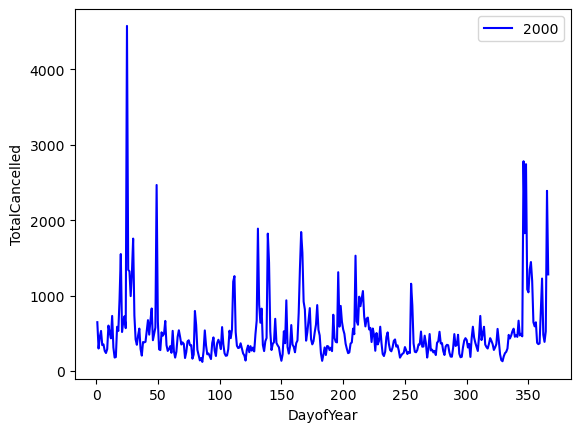

In [44]:
#Année 2000
sns.lineplot(data=pandas_daily_cancelled_2000, x="DayofYear", y="TotalCancelled", color="blue", label="2000")

À partir de cette courbe, nous pouvons conclure qu'en 2000, le maximum des vols annulés a été enregistré aux environs du 30e jour de l'année.

<Axes: xlabel='DayofYear', ylabel='TotalCancelled'>

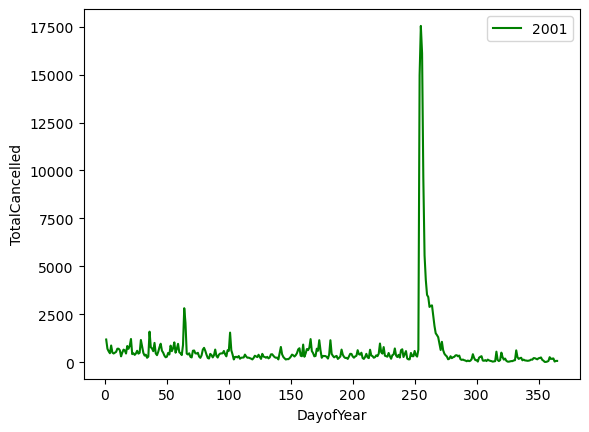

In [46]:
#Année 2001
sns.lineplot(data=pandas_daily_cancelled_2001, x="DayofYear", y="TotalCancelled", color="green", label="2001")

Cette courbe montre qu'en 2001, le nombre maximal de vols annulés a été atteint autour du 255e jour de l'année.

<Axes: xlabel='DayofYear', ylabel='TotalCancelled'>

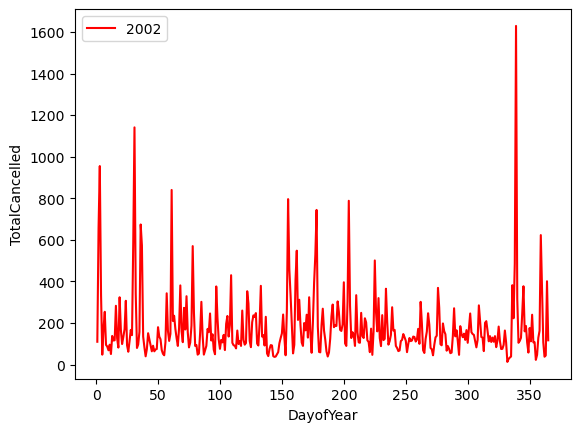

In [48]:
#Année 2002
sns.lineplot(data=pandas_daily_cancelled_2002, x="DayofYear", y="TotalCancelled", color="red", label="2002")

D'après cette courbe, en 2002, les vols annulés ont culminé vers le 340e jour de l'année.

## VI. Moyenne des vols annulés le 25 decembre

Ici, nous avons calculé la moyenne du nombre total de vols annulés pour tous les 25 décembre au cours des trois années consécutives.

In [52]:
#Filtrage des vols annulés le 25 decembre
cancelledDF = secondDF.filter((col("Cancelled") == 1) & (col("Month") == 12) & (col("DayofMonth") == 25))

In [53]:
#Requete
#Calcul du nombre total de vols annulés par années
daily_cancelled_flights = cancelledDF.groupBy("Year") \
                                         .agg(F.count("Cancelled").alias("TotalCancelled"))


In [54]:
#Moyenne du nombre total de vols annulés par année sur toutes les années
average_cancelled_flights = daily_cancelled_flights.agg(F.avg("TotalCancelled")).collect()[0][0]

In [55]:
#Affichage du resultat obtenu
print(f"Moyenne des vols annulés le 25 décembre sur les années 2000, 2001 et 2002 : {average_cancelled_flights}")

Moyenne des vols annulés le 25 décembre sur les années 2000, 2001 et 2002 : 568.3333333333334


## Résumé

 L'analyse des données d'annulations de vols a mis en évidence des modèles temporels importants, permettant d'identifier les mois et jours avec le plus grand nombre d'annulations. Ces informations sont essentielles pour ajuster les stratégies opérationnelles et améliorer la satisfaction des passagers.